# 🎯 Knowledge Tracing with AKT + LLM Pipeline

## Objective
Predict whether a student will answer a question **Correctly** or **Incorrectly** by combining:
1. **Question Context** - Text embeddings from the LLM itself
2. **Student History Context** - Learning state embeddings from the AKT model

## Pipeline Overview
| Step | Description |
|------|-------------|
| 1. Setup | Load config, select preset (small/standard), initialize wandb |
| 2. EDA | Load dataset, explore data distribution, understand features |
| 3. AKT Training | Train Attentive Knowledge Tracing model, checkpoint best model |
| 4. Embedding Extraction | Get student history embeddings from trained AKT |
| 5. LLM Fine-tuning | Adapt LLM to understand both question text + history embeddings |
| 6. Evaluation | Test predictions on validation samples |

## Model Presets
- **small**: TinyLlama-1.1B, minimal data, for quick testing
- **standard**: Phi-2, balanced performance  
- **phi3**: Phi-3 Mini, excellent quality
- **qwen**: Qwen2-1.5B, good multilingual support
- **llama2**: Llama-2-7B, highest quality (needs more GPU)


In [ ]:
# ============================================================================
# STEP 1: SETUP - Load Configuration & Initialize Environment
# ============================================================================

import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

warnings.filterwarnings('ignore')

# Load environment variables (includes proxy settings, WandB API key, and HF token)
load_dotenv()

# Set proxy environment variables for network requests
if os.getenv('HTTP_PROXY'):
    os.environ['HTTP_PROXY'] = os.getenv('HTTP_PROXY')
    os.environ['HTTPS_PROXY'] = os.getenv('HTTPS_PROXY')
    os.environ['http_proxy'] = os.getenv('http_proxy')
    os.environ['https_proxy'] = os.getenv('https_proxy')
    print("✓ Proxy settings loaded from .env file")
    print(f"  HTTP Proxy: {os.environ['HTTP_PROXY']}")
    print(f"  HTTPS Proxy: {os.environ['HTTPS_PROXY']}")

# Set Hugging Face token for model downloads
if os.getenv('HF_TOKEN'):
    os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
    os.environ['HUGGING_FACE_HUB_TOKEN'] = os.getenv('HF_TOKEN')
    print("✓ Hugging Face token loaded from .env file")

# Load configuration
from config import Config

# ============================================================================
# SELECT YOUR PRESET HERE
# ============================================================================
# Options: "small" (testing), "standard" (balanced), "phi3", "qwen", "llama2"

PRESET = "small"  # ← Change this to switch models

# Apply the preset
Config.use_preset(PRESET)

# Show available presets
print("\n")
Config.list_presets()

# Show full configuration
print("\n")
Config.print_config()

# ============================================================================
# CREATE ALL NECESSARY DIRECTORIES
# ============================================================================
print("\n" + "=" * 70)
print("CREATING DIRECTORY STRUCTURE")
print("=" * 70)

directories_to_create = [
    (Config.AKT_CHECKPOINT_DIR, "AKT Model Checkpoints"),
    (Config.LLM_CHECKPOINT_DIR, "LLM Model Checkpoints"),
    (Config.CHECKPOINT_DIR, "General Checkpoints"),
    (Config.EMBEDDING_DIR, "Student Embeddings"),
    (Config.OUTPUT_DIR, "Training Outputs & Plots"),
    (Config.AKT_LOG_DIR, "Training Logs"),
    (Config.DATA_DIR, "Dataset Files"),
    ('assets', "Visualizations & Assets")
]

for dir_path, description in directories_to_create:
    os.makedirs(dir_path, exist_ok=True)
    print(f"  ✓ {description:30} → {dir_path}")

print("=" * 70)
print("✓ All directories created successfully")
print("=" * 70)

print(f"\n✓ Using device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✓ Proxy settings loaded from .env file
  HTTP Proxy: http://10.61.11.42:3128
  HTTPS Proxy: http://10.61.11.42:3128
✓ Hugging Face token loaded from .env file
✓ Applied preset: Small (Testing)
  Minimal configuration for quick testing and debugging
  LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Embedding dim: 768 → LLM hidden: 2048
✓ Applied preset: Small (Testing)
  Minimal configuration for quick testing and debugging
  LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Embedding dim: 768 → LLM hidden: 2048



AVAILABLE MODEL PRESETS

📦 small ← ACTIVE
   Name: Small (Testing)
   Description: Minimal configuration for quick testing and debugging
   LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
   Hidden Size: 2048
   Data: 5 users, 100 interactions

📦 standard
   Name: Standard (Balanced)
   Description: Balanced configuration for good results with reasonable resources
   LLM: microsoft/phi-2
   Hidden Size: 2560
   Data: 100 users, 5000 interactions

📦 phi3
   Name: Phi-3 Mini
   Description: Microsof

## Step 2: Load Dataset & Exploratory Data Analysis (EDA)

In this section we:
1. Load the MOOCRadar dataset (problems and student interactions)
2. Explore data distributions (correctness, skills, users)
3. Understand the data structure for model training


LOADING MOOCRADAR DATASET

[2.0] Checking dataset files...
✓ Using cached file: dataset/MOOCRadar/problem.json
✓ Using cached file: dataset/MOOCRadar/student-problem-coarse-flattened.json

[2.1] Loading problem metadata...
✓ Loaded 9383 problems

Sample problem structure:
  • problem_id: Pm_2046133
  • exercise_id: Ex_1641736
  • course_id: C_674920
  • detail: {'problem_id': 2046133, 'title': '第一章作业', 'content...
  • knowledge_type: 2
  • cognitive_dimension: 4
  • concepts: ['经济发展逻辑', '逻辑学']

[2.2] Loading student interactions...
✓ Loaded 898933 total interactions

Sample interaction structure:
  • log_id: 1002476_5940094
  • problem_id: Pm_668265
  • user_id: U_1002476
  • is_correct: 1
  • attempts: 1
  • score: None
  • submit_time: 2020-12-13 12:02:59
  • skill_id: C_697360
  • course_id: C_697360

[2.3] Enriching interactions with problem metadata...
✓ Using 100 interactions (limit: 100)

EXPLORATORY DATA ANALYSIS

📊 Dataset Overview:
  • Total interactions: 100
  • Unique users

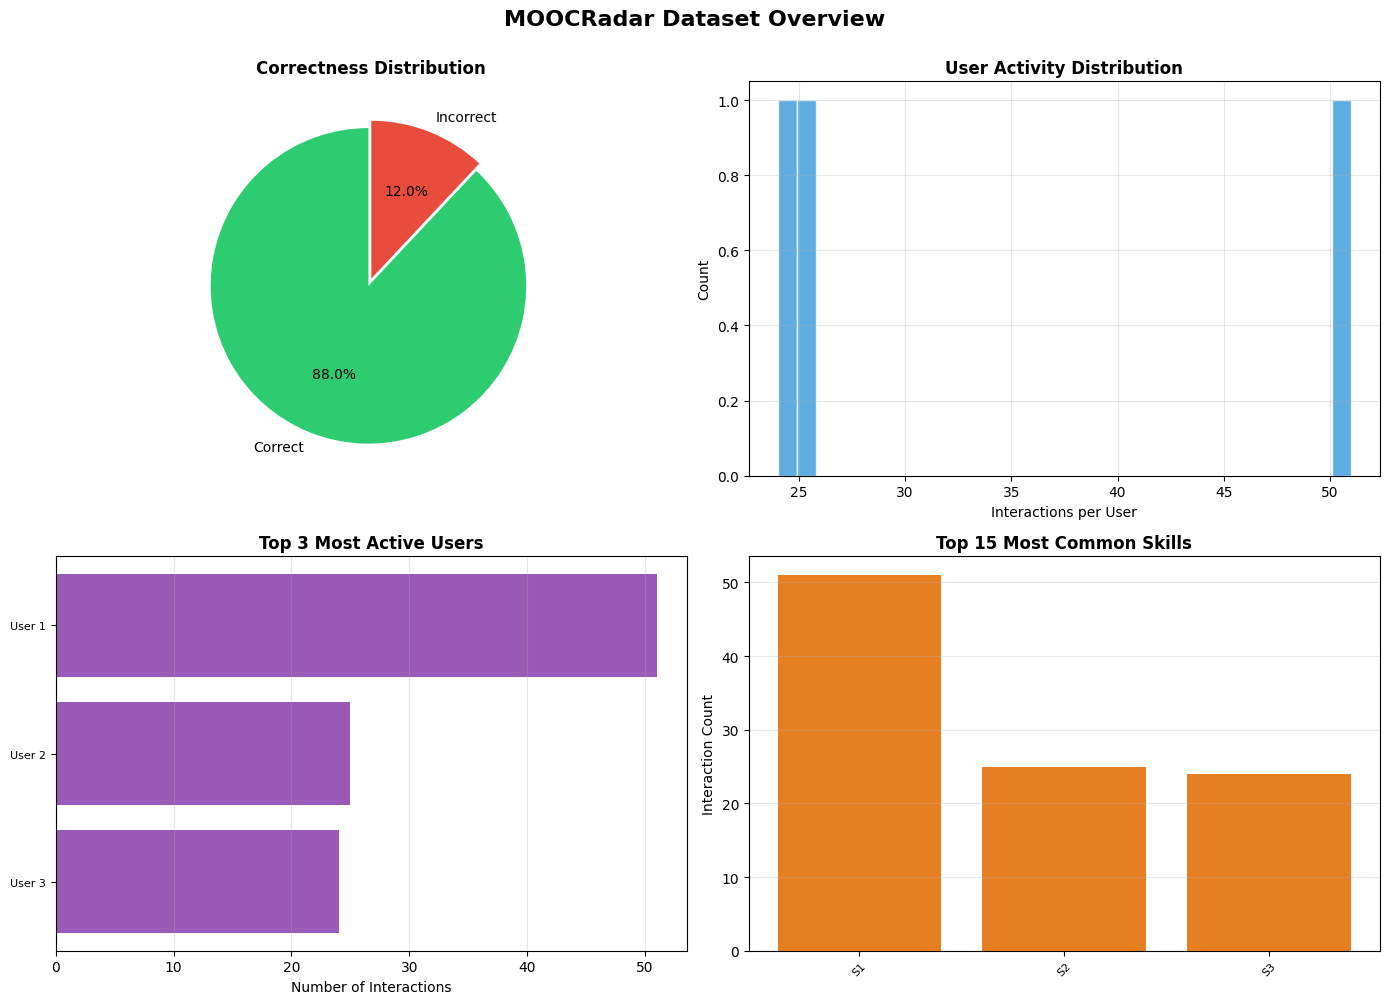


✓ Visualization saved to: assets/dataset_analysis.png

[2.5] Grouping interactions by student...
✓ Found 3 users with ≥5 interactions

[2.6] Encoding categorical variables...
✓ Encoded 100 unique problems
✓ Encoded 3 unique skills

[2.7] Splitting into train/validation sets...
✓ Train users: 2
✓ Val users: 1

[2.8] Preparing student sequences for AKT...
✓ Prepared 3 student sequences
  • Avg sequence length: 33.3

DATA LOADING COMPLETE


In [2]:
# ============================================================================
# STEP 2: LOAD DATASET & EDA
# ============================================================================

print("=" * 70)
print("LOADING MOOCRADAR DATASET")
print("=" * 70)

# -----------------------------------------------------------------------------
# 2.0 Download Dataset from Google Drive (with caching)
# -----------------------------------------------------------------------------
def download_from_gdrive(file_id, output_path):
    """Download file from Google Drive if not already cached locally."""
    if os.path.exists(output_path):
        print(f"✓ Using cached file: {output_path}")
        return output_path
    
    print(f"⬇️  Downloading from Google Drive to {output_path}...")
    
    # Create directory if needed
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Try using gdown first (more reliable)
    try:
        import gdown
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, output_path, quiet=False)
        print(f"✓ Download complete: {output_path}")
        return output_path
    except ImportError:
        print("⚠️  gdown not installed. Installing...")
        import subprocess
        subprocess.check_call([os.sys.executable, "-m", "pip", "install", "gdown", "--quiet"])
        import gdown
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, output_path, quiet=False)
        print(f"✓ Download complete: {output_path}")
        return output_path
    except Exception as e:
        print(f"❌ Error downloading file: {e}")
        raise

print("\n[2.0] Checking dataset files...")

# Download/cache problem.json
problem_json_path = download_from_gdrive(
    Config.GDRIVE_FILES["problem.json"],
    Config.PROBLEM_JSON
)

# Download/cache student interactions
student_json_path = download_from_gdrive(
    Config.GDRIVE_FILES["student-problem-coarse-flattened.json"],
    Config.STUDENT_JSON
)

# -----------------------------------------------------------------------------
# 2.1 Load Problem Metadata (JSONL format - one JSON per line)
# -----------------------------------------------------------------------------
print("\n[2.1] Loading problem metadata...")
problem_info = {}
with open(problem_json_path, 'r', encoding='utf-8') as f:
    for line in f:
        problem = json.loads(line)
        problem_info[problem['problem_id']] = problem

print(f"✓ Loaded {len(problem_info)} problems")

# Sample problem structure
sample_problem = list(problem_info.values())[0]
print(f"\nSample problem structure:")
for key in sample_problem.keys():
    value = sample_problem[key]
    if isinstance(value, str) and len(value) > 50:
        value = value[:50] + "..."
    print(f"  • {key}: {value}")

# -----------------------------------------------------------------------------
# 2.2 Load Student Interactions (JSON array format)
# -----------------------------------------------------------------------------
print("\n[2.2] Loading student interactions...")
with open(student_json_path, 'r', encoding='utf-8') as f:
    interactions_raw = json.load(f)  # Load entire JSON array

print(f"✓ Loaded {len(interactions_raw)} total interactions")

# Sample interaction structure
sample_interaction = interactions_raw[0]
print(f"\nSample interaction structure:")
for key in sample_interaction.keys():
    print(f"  • {key}: {sample_interaction[key]}")

# -----------------------------------------------------------------------------
# 2.3 Enrich Data & Apply Limits
# -----------------------------------------------------------------------------
print("\n[2.3] Enriching interactions with problem metadata...")
data = []
for interaction in interactions_raw[:Config.MAX_INTERACTIONS]:
    problem_id = interaction['problem_id']
    enriched = interaction.copy()
    
    if problem_id in problem_info:
        enriched['problem_detail'] = problem_info[problem_id].get('detail', '')
        enriched['concepts'] = problem_info[problem_id].get('concepts', [])
        enriched['knowledge_type'] = problem_info[problem_id].get('knowledge_type', 0)
        enriched['cognitive_dimension'] = problem_info[problem_id].get('cognitive_dimension', 0)
    
    data.append(enriched)

print(f"✓ Using {len(data)} interactions (limit: {Config.MAX_INTERACTIONS})")

# Convert to DataFrame for EDA
df = pd.DataFrame(data)

# -----------------------------------------------------------------------------
# 2.4 Exploratory Data Analysis
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 70)

print("\n📊 Dataset Overview:")
print(f"  • Total interactions: {len(df):,}")
print(f"  • Unique users: {df['user_id'].nunique():,}")
print(f"  • Unique problems: {df['problem_id'].nunique():,}")
print(f"  • Unique skills: {df['skill_id'].nunique():,}")

# Correctness distribution
correct_rate = df['is_correct'].mean()
print(f"\n📈 Correctness Distribution:")
print(f"  • Correct: {df['is_correct'].sum():,} ({correct_rate*100:.1f}%)")
print(f"  • Incorrect: {(~df['is_correct'].astype(bool)).sum():,} ({(1-correct_rate)*100:.1f}%)")

# Interactions per user
interactions_per_user = df.groupby('user_id').size()
print(f"\n👤 Interactions per User:")
print(f"  • Mean: {interactions_per_user.mean():.1f}")
print(f"  • Min: {interactions_per_user.min()}")
print(f"  • Max: {interactions_per_user.max()}")
print(f"  • Median: {interactions_per_user.median():.1f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Correctness Distribution
ax1 = axes[0, 0]
colors = ['#2ecc71', '#e74c3c']
correct_counts = [df['is_correct'].sum(), (~df['is_correct'].astype(bool)).sum()]
ax1.pie(correct_counts, labels=['Correct', 'Incorrect'], colors=colors, autopct='%1.1f%%',
        startangle=90, explode=(0.05, 0))
ax1.set_title('Correctness Distribution', fontsize=12, fontweight='bold')

# 2. Interactions per User Distribution
ax2 = axes[0, 1]
ax2.hist(interactions_per_user, bins=30, color='#3498db', edgecolor='white', alpha=0.8)
ax2.set_xlabel('Interactions per User', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_title('User Activity Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Top 15 Most Active Users
ax3 = axes[1, 0]
top_users = interactions_per_user.nlargest(min(15, len(interactions_per_user)))
ax3.barh(range(len(top_users)), top_users.values, color='#9b59b6')
ax3.set_yticks(range(len(top_users)))
ax3.set_yticklabels([f"User {i+1}" for i in range(len(top_users))], fontsize=8)
ax3.set_xlabel('Number of Interactions', fontsize=10)
ax3.set_title(f'Top {len(top_users)} Most Active Users', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# 4. Skill Distribution (Top 15)
ax4 = axes[1, 1]
skill_counts = df['skill_id'].value_counts().head(15)
ax4.bar(range(len(skill_counts)), skill_counts.values, color='#e67e22')
ax4.set_xticks(range(len(skill_counts)))
ax4.set_xticklabels([f"S{i+1}" for i in range(len(skill_counts))], fontsize=8, rotation=45)
ax4.set_ylabel('Interaction Count', fontsize=10)
ax4.set_title('Top 15 Most Common Skills', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('MOOCRadar Dataset Overview', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
os.makedirs('assets', exist_ok=True)
plt.savefig('assets/dataset_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: assets/dataset_analysis.png")

# -----------------------------------------------------------------------------
# 2.5 Prepare Student Sequences
# -----------------------------------------------------------------------------
print("\n[2.5] Grouping interactions by student...")
user_groups = df.groupby('user_id')

# Filter users with enough interactions
min_interactions = 5
user_groups_filtered = [(uid, group) for uid, group in user_groups if len(group) >= min_interactions]

print(f"✓ Found {len(user_groups_filtered)} users with ≥{min_interactions} interactions")

# Apply MAX_USERS limit
if len(user_groups_filtered) > Config.MAX_USERS:
    user_groups_filtered = user_groups_filtered[:Config.MAX_USERS]
    print(f"✓ Using {Config.MAX_USERS} users (limited by config)")

# -----------------------------------------------------------------------------
# 2.6 Encode Categorical Variables
# -----------------------------------------------------------------------------
print("\n[2.6] Encoding categorical variables...")

# Collect all unique values from filtered users
all_problems = []
all_skills = []
for uid, group in user_groups_filtered:
    all_problems.extend(group['problem_id'].tolist())
    all_skills.extend(group['skill_id'].tolist())

# Create encoders
problem_encoder = LabelEncoder()
skill_encoder = LabelEncoder()

problem_encoder.fit(list(set(all_problems)))
skill_encoder.fit(list(set(all_skills)))

# Save encoder info
num_problems = len(problem_encoder.classes_)
num_skills = len(skill_encoder.classes_)

# Create aliases for AKT model (questions = problems, concepts = skills)
num_questions = num_problems
num_concepts = num_skills

print(f"✓ Encoded {num_problems} unique problems")
print(f"✓ Encoded {num_skills} unique skills")

# -----------------------------------------------------------------------------
# 2.7 Train/Val Split (with edge case handling)
# -----------------------------------------------------------------------------
print("\n[2.7] Splitting into train/validation sets...")

# Check if we have enough users for splitting
if len(user_groups_filtered) < 2:
    print(f"⚠️  WARNING: Only {len(user_groups_filtered)} user(s) available.")
    print("   Using the same data for both train and validation (for testing purposes only)")
    train_user_groups = user_groups_filtered
    val_user_groups = user_groups_filtered
else:
    train_user_groups, val_user_groups = train_test_split(
        user_groups_filtered, 
        test_size=Config.TEST_SIZE, 
        random_state=Config.RANDOM_SEED
    )

print(f"✓ Train users: {len(train_user_groups)}")
print(f"✓ Val users: {len(val_user_groups)}")

# -----------------------------------------------------------------------------
# 2.8 Prepare Student Data for AKT Training
# -----------------------------------------------------------------------------
print("\n[2.8] Preparing student sequences for AKT...")

students_data = []
for uid, group in train_user_groups + val_user_groups:
    # Sort by timestamp if available
    if 'timestamp_TW' in group.columns:
        group = group.sort_values('timestamp_TW')
    
    # Encode sequences
    questions = problem_encoder.transform(group['problem_id'].tolist())
    concepts = skill_encoder.transform(group['skill_id'].tolist())
    correctness = group['is_correct'].astype(int).tolist()
    
    students_data.append({
        'user_id': uid,
        'questions': questions.tolist(),
        'concepts': concepts.tolist(),
        'correctness': correctness
    })

print(f"✓ Prepared {len(students_data)} student sequences")
print(f"  • Avg sequence length: {np.mean([len(s['questions']) for s in students_data]):.1f}")

print("\n" + "=" * 70)
print("DATA LOADING COMPLETE")
print("=" * 70)

## Step 3: Build AKT Model & Train

The Attentive Knowledge Tracing (AKT) model:
1. Captures student learning history through attention mechanisms
2. Generates embeddings representing student knowledge state
3. These embeddings will be used as "history context" for LLM fine-tuning

**Architecture:**
- Question/Concept Embeddings → Transformer Encoder → Knowledge State
- Output: `EMBED_DIM`-dimensional embedding per student (matching LLM hidden size)


In [10]:
# ============================================================================
# STEP 3: BUILD AKT MODEL
# ============================================================================

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

print("=" * 70)
print("STEP 3: BUILD ATTENTIVE KNOWLEDGE TRACING (AKT) MODEL")
print("=" * 70)

# -----------------------------------------------------------------------------
# 3.1 Dataset Class for Knowledge Tracing
# -----------------------------------------------------------------------------
class KTDataset(Dataset):
    """Dataset for Knowledge Tracing sequences"""
    def __init__(self, students_data, max_seq_len=100):
        self.students = students_data
        self.max_seq_len = max_seq_len
    
    def __len__(self):
        return len(self.students)
    
    def __getitem__(self, idx):
        student = self.students[idx]
        questions = student['questions'][-self.max_seq_len:]
        concepts = student['concepts'][-self.max_seq_len:]
        correctness = student['correctness'][-self.max_seq_len:]
        
        seq_len = len(questions)
        pad_len = self.max_seq_len - seq_len
        
        # Pad sequences
        questions = questions + [0] * pad_len
        concepts = concepts + [0] * pad_len
        correctness = correctness + [0] * pad_len
        mask = [1] * seq_len + [0] * pad_len
        
        return {
            'questions': torch.LongTensor(questions),
            'concepts': torch.LongTensor(concepts),
            'correctness': torch.FloatTensor(correctness),
            'mask': torch.FloatTensor(mask)
        }

# -----------------------------------------------------------------------------
# 3.2 Data Module for PyTorch Lightning
# -----------------------------------------------------------------------------
class KTDataModule(pl.LightningDataModule):
    def __init__(self, students_data, batch_size=64, max_seq_len=100, test_size=0.2):
        super().__init__()
        self.students_data = students_data
        self.batch_size = batch_size
        self.max_seq_len = max_seq_len
        self.test_size = test_size
        
    def setup(self, stage=None):
        train_data, val_data = train_test_split(
            self.students_data, 
            test_size=self.test_size, 
            random_state=Config.RANDOM_SEED
        )
        self.train_dataset = KTDataset(train_data, self.max_seq_len)
        self.val_dataset = KTDataset(val_data, self.max_seq_len)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

# -----------------------------------------------------------------------------
# 3.3 AKT Model with PyTorch Lightning
# -----------------------------------------------------------------------------
class AKTLightning(pl.LightningModule):
    """Attentive Knowledge Tracing model with PyTorch Lightning"""
    
    def __init__(self, num_questions, num_concepts, embed_dim=768, num_heads=8, 
                 num_layers=2, dropout=0.15, learning_rate=5e-5, weight_decay=1e-4,
                 warmup_epochs=5, label_smoothing=0.1):
        super().__init__()
        self.save_hyperparameters()
        
        self.embed_dim = embed_dim
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.warmup_epochs = warmup_epochs
        self.label_smoothing = label_smoothing
        
        # Embeddings
        self.question_embed = nn.Embedding(num_questions + 1, embed_dim, padding_idx=0)
        self.concept_embed = nn.Embedding(num_concepts + 1, embed_dim, padding_idx=0)
        self.response_embed = nn.Embedding(3, embed_dim)  # 0: pad, 1: incorrect, 2: correct
        self.position_embed = nn.Embedding(500, embed_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, 
            dim_feedforward=embed_dim * 4, dropout=dropout,
            activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(embed_dim, 1)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
    
    def forward(self, questions, concepts, correctness, mask):
        batch_size, seq_len = questions.shape
        
        # Create position indices
        positions = torch.arange(seq_len, device=questions.device).unsqueeze(0).expand(batch_size, -1)
        
        # Combine embeddings
        q_emb = self.question_embed(questions)
        c_emb = self.concept_embed(concepts)
        
        # Response embedding (shift by 1 for padding)
        response_idx = (correctness + 1).long()  # 0->1 (incorrect), 1->2 (correct)
        r_emb = self.response_embed(response_idx)
        
        # Position embedding
        p_emb = self.position_embed(positions)
        
        # Combine all embeddings
        x = q_emb + c_emb + r_emb + p_emb
        
        # Create attention mask for transformer
        src_key_padding_mask = (mask == 0)
        
        # Create causal mask to prevent looking at future
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        
        # Transformer encoding
        x = self.transformer(x, mask=causal_mask, src_key_padding_mask=src_key_padding_mask)
        
        # Layer norm and dropout
        x = self.layer_norm(x)
        x = self.dropout(x)
        
        # Output prediction
        output = self.output_layer(x).squeeze(-1)
        
        return output, x  # Return both predictions and embeddings
    
    def training_step(self, batch, batch_idx):
        questions, concepts, correctness, mask = batch['questions'], batch['concepts'], batch['correctness'], batch['mask']
        
        predictions, _ = self(questions, concepts, correctness, mask)
        
        # Shift for next-step prediction
        pred_shifted = predictions[:, :-1]
        target_shifted = correctness[:, 1:]
        mask_shifted = mask[:, 1:]
        
        # Calculate loss with label smoothing
        loss = self._compute_loss(pred_shifted, target_shifted, mask_shifted)
        
        # Calculate accuracy
        with torch.no_grad():
            pred_binary = (torch.sigmoid(pred_shifted) > 0.5).float()
            correct = ((pred_binary == target_shifted) * mask_shifted).sum()
            total = mask_shifted.sum()
            acc = correct / (total + 1e-8)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        questions, concepts, correctness, mask = batch['questions'], batch['concepts'], batch['correctness'], batch['mask']
        
        predictions, _ = self(questions, concepts, correctness, mask)
        
        pred_shifted = predictions[:, :-1]
        target_shifted = correctness[:, 1:]
        mask_shifted = mask[:, 1:]
        
        loss = self._compute_loss(pred_shifted, target_shifted, mask_shifted)
        
        pred_binary = (torch.sigmoid(pred_shifted) > 0.5).float()
        correct = ((pred_binary == target_shifted) * mask_shifted).sum()
        total = mask_shifted.sum()
        acc = correct / (total + 1e-8)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def _compute_loss(self, predictions, targets, mask):
        # Binary cross entropy with label smoothing
        smooth_targets = targets * (1 - self.label_smoothing) + 0.5 * self.label_smoothing
        loss = nn.functional.binary_cross_entropy_with_logits(
            predictions, smooth_targets, reduction='none'
        )
        masked_loss = (loss * mask).sum() / (mask.sum() + 1e-8)
        return masked_loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=self.warmup_epochs, T_mult=2
        )
        return [optimizer], [scheduler]
    
    def get_embeddings(self, dataloader):
        """Extract student knowledge state embeddings"""
        self.eval()
        embeddings = []
        
        with torch.no_grad():
            for batch in dataloader:
                questions = batch['questions'].to(self.device)
                concepts = batch['concepts'].to(self.device)
                correctness = batch['correctness'].to(self.device)
                mask = batch['mask'].to(self.device)
                
                _, hidden = self(questions, concepts, correctness, mask)
                
                # Get last valid position embedding for each student
                for i in range(hidden.size(0)):
                    valid_len = int(mask[i].sum().item())
                    if valid_len > 0:
                        student_emb = hidden[i, valid_len - 1, :].cpu().numpy()
                    else:
                        student_emb = hidden[i, 0, :].cpu().numpy()
                    embeddings.append(student_emb)
        
        return np.array(embeddings)

print("✓ AKT Model classes defined:")
print(f"  • KTDataset: Handles sequence padding and batching")
print(f"  • KTDataModule: PyTorch Lightning data module")
print(f"  • AKTLightning: Transformer-based knowledge tracing model")
print(f"\nModel Configuration (from Config):")
print(f"  • Embedding Dim: {Config.EMBED_DIM}")
print(f"  • Attention Heads: {Config.NUM_HEADS}")
print(f"  • Transformer Layers: {Config.NUM_LAYERS}")
print(f"  • Dropout: {Config.AKT_DROPOUT}")


STEP 3: BUILD ATTENTIVE KNOWLEDGE TRACING (AKT) MODEL
✓ AKT Model classes defined:
  • KTDataset: Handles sequence padding and batching
  • KTDataModule: PyTorch Lightning data module
  • AKTLightning: Transformer-based knowledge tracing model

Model Configuration (from Config):
  • Embedding Dim: 768
  • Attention Heads: 4
  • Transformer Layers: 2
  • Dropout: 0.15


In [11]:
# ============================================================================
# STEP 3.4: TRAIN AKT MODEL
# ============================================================================

import wandb
from pytorch_lightning.loggers import WandbLogger

print("=" * 70)
print("TRAINING AKT MODEL")
print("=" * 70)

# Initialize data module
print("\n[3.4.1] Setting up data module...")
data_module = KTDataModule(
    students_data, 
    batch_size=Config.AKT_BATCH_SIZE, 
    max_seq_len=Config.MAX_SEQ_LEN,
    test_size=Config.TEST_SIZE
)
data_module.setup()
print(f"✓ Train: {len(data_module.train_dataset)} students")
print(f"✓ Val: {len(data_module.val_dataset)} students")

# Initialize model
print("\n[3.4.2] Initializing AKT model...")
model = AKTLightning(
    num_questions=num_questions,
    num_concepts=num_concepts,
    embed_dim=Config.EMBED_DIM,
    num_heads=Config.NUM_HEADS,
    num_layers=Config.NUM_LAYERS,
    dropout=Config.AKT_DROPOUT,
    learning_rate=Config.AKT_LR,
    weight_decay=Config.AKT_WEIGHT_DECAY,
    warmup_epochs=Config.AKT_WARMUP_EPOCHS,
    label_smoothing=Config.AKT_LABEL_SMOOTHING
)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model initialized with {trainable_params:,} trainable parameters")

# Setup callbacks
print("\n[3.4.3] Setting up training callbacks...")
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath=Config.AKT_CHECKPOINT_DIR,
    filename='akt-{epoch:02d}-{val_acc:.4f}',
    save_top_k=1,
    mode='max'
)

early_stop_callback = EarlyStopping(
    monitor='val_acc',
    patience=Config.AKT_EARLY_STOP_PATIENCE,
    mode='max',
    min_delta=0.001
)

# Setup loggers
csv_logger = CSVLogger(Config.AKT_LOG_DIR, name='akt_training')
loggers = [csv_logger]

# Initialize wandb if enabled
if Config.USE_WANDB:
    wandb_run = wandb.init(
        entity=Config.WANDB_ENTITY,
        project=Config.WANDB_PROJECT,
        name=f"AKT-{Config.ACTIVE_PRESET}",
        config={
            "preset": Config.ACTIVE_PRESET,
            "model": "AKT",
            "embed_dim": Config.EMBED_DIM,
            "num_heads": Config.NUM_HEADS,
            "num_layers": Config.NUM_LAYERS,
            "batch_size": Config.AKT_BATCH_SIZE,
            "learning_rate": Config.AKT_LR,
            "epochs": Config.AKT_EPOCHS,
            "num_students": len(students_data),
            "num_questions": num_questions,
            "num_concepts": num_concepts,
        }
    )
    wandb_logger = WandbLogger(experiment=wandb_run)
    loggers.append(wandb_logger)
    print(f"✓ Wandb initialized: {wandb_run.name}")
    print(f"  → View at: {wandb_run.get_url()}")

# Initialize trainer
print("\n[3.4.4] Starting training...")
trainer = pl.Trainer(
    max_epochs=Config.AKT_EPOCHS,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=loggers,
    accelerator='auto' if Config.USE_GPU else 'cpu',
    devices=1,
    log_every_n_steps=10,
    enable_progress_bar=True,
    accumulate_grad_batches=Config.GRADIENT_ACCUMULATION,
    precision='16-mixed' if Config.MIXED_PRECISION else 32,
    gradient_clip_val=1.0,
    gradient_clip_algorithm='norm'
)

print("\n" + "🏋️ " * 35)
trainer.fit(model, data_module)
print("🏋️ " * 35)

print(f"\n✓ Training completed!")
print(f"✓ Best checkpoint: {checkpoint_callback.best_model_path}")
print(f"✓ Best validation accuracy: {checkpoint_callback.best_model_score:.4f}")

# Load best model
print("\n[3.4.5] Loading best model for embedding extraction...")
best_model = AKTLightning.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    num_questions=num_questions,
    num_concepts=num_concepts
)
print("✓ Best model loaded")

# -----------------------------------------------------------------------------
# 3.5 Plot Training Curves
# -----------------------------------------------------------------------------
print("\n[3.5] Plotting training curves...")

# Read metrics from CSV logger
metrics_path = f'{Config.AKT_LOG_DIR}/akt_training/version_{csv_logger.version}/metrics.csv'
metrics_df = pd.read_csv(metrics_path)

# Check what columns are available
print(f"Available columns: {list(metrics_df.columns)}")

# PyTorch Lightning logs metrics with 'train/' and 'val/' prefixes or without
# Let's handle both cases
train_loss_col = None
train_acc_col = None
val_loss_col = None
val_acc_col = None

for col in metrics_df.columns:
    if 'train' in col.lower() and 'loss' in col.lower():
        train_loss_col = col
    elif 'train' in col.lower() and 'acc' in col.lower():
        train_acc_col = col
    elif 'val' in col.lower() and 'loss' in col.lower():
        val_loss_col = col
    elif 'val' in col.lower() and 'acc' in col.lower():
        val_acc_col = col

if train_loss_col and val_loss_col:
    # Prepare data
    train_metrics = metrics_df[metrics_df[train_loss_col].notna()][['epoch', train_loss_col, train_acc_col]]
    train_metrics.columns = ['epoch', 'train_loss', 'train_acc']
    
    val_metrics = metrics_df[metrics_df[val_loss_col].notna()][['epoch', val_loss_col, val_acc_col]]
    val_metrics.columns = ['epoch', 'val_loss', 'val_acc']
    
    metrics_combined = pd.merge(
        train_metrics.groupby('epoch').mean().reset_index(),
        val_metrics.groupby('epoch').mean().reset_index(),
        on='epoch'
    )
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    axes[0].plot(metrics_combined['epoch'], metrics_combined['train_loss'], 'b-o', label='Train', markersize=6)
    axes[0].plot(metrics_combined['epoch'], metrics_combined['val_loss'], 'r-s', label='Val', markersize=6)
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('AKT Training - Loss', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(metrics_combined['epoch'], metrics_combined['train_acc'], 'b-o', label='Train', markersize=6)
    axes[1].plot(metrics_combined['epoch'], metrics_combined['val_acc'], 'r-s', label='Val', markersize=6)
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Accuracy', fontsize=11)
    axes[1].set_title('AKT Training - Accuracy', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('akt_training_curves.png', dpi=300, bbox_inches='tight')
    print("✓ Training curves saved as 'akt_training_curves.png'")
    plt.show()
else:
    print("⚠️ Could not find expected metric columns in CSV. Skipping plot.")
    print(f"Available columns: {list(metrics_df.columns)}")

print("\n" + "=" * 70)
print("✓ AKT MODEL TRAINING COMPLETE")
print("=" * 70)

TRAINING AKT MODEL

[3.4.1] Setting up data module...
✓ Train: 2 students
✓ Val: 1 students

[3.4.2] Initializing AKT model...
✓ Model initialized with 14,644,993 trainable parameters

[3.4.3] Setting up training callbacks...


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▃▅▆█
trainer/global_step,▁▃▅▆█
val_acc,▁▁▁▁▁
val_loss,█▆▂▁▁
epoch,4
trainer/global_step,4
val_acc,0.91304
val_loss,0.57224


Using bfloat16 Automatic Mixed Precision (AMP)


✓ Wandb initialized: AKT-small
  → View at: https://wandb.ai/letrongducanh456-viettel/LLM-KT/runs/zrnrugd3

[3.4.4] Starting training...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.



🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 



  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | question_embed | Embedding          | 77.6 K | train | 0    
1 | concept_embed  | Embedding          | 3.1 K  | train | 0    
2 | response_embed | Embedding          | 2.3 K  | train | 0    
3 | position_embed | Embedding          | 384 K  | train | 0    
4 | transformer    | TransformerEncoder | 14.2 M | train | 0    
5 | layer_norm     | LayerNorm          | 1.5 K  | train | 0    
6 | dropout        | Dropout            | 0      | train | 0    
7 | output_layer   | Linear             | 769    | train | 0    
----------------------------------------------------------------------
14.6 M    Trainable params
0         Non-trainable params
14.6 M    Total params
58.580    Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, v_num=ugd3, train_loss=0.513, train_acc=0.890, val_loss=0.473, val_acc=0.913]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, v_num=ugd3, train_loss=0.513, train_acc=0.890, val_loss=0.473, val_acc=0.913]
🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 🏋️ 

✓ Training completed!
✓ Best checkpoint: C:\Users\DUCANH\OneDrive - VNU-HCMUS\Desktop\AI tutor\LLM-KT\checkpoints\akt\small\akt-epoch=00-val_acc=0.9130-v1.ckpt
✓ Best validation accuracy: 0.9130

[3.4.5] Loading best model for embedding extraction...
✓ Best model loaded

[3.5] Plotting training curves...
Available columns: ['epoch', 'step', 'val_acc', 'val_loss']
⚠️ Could not find expected metric columns in CSV. Skipping plot.
Available columns: ['epoch', 'step', 'val_acc', 'val_loss']

✓ AKT MODEL TRAINING COMPLETE


## Step 4: Extract Embeddings & Prepare for LLM Fine-tuning

Now we extract two types of embeddings for the LLM:

1. **Student History Embeddings** (from AKT)
   - Captures the student's learning history and knowledge state
   - Dimension: `EMBED_DIM` (configured to match or adapt to LLM)

2. **Question Context Embeddings** (from LLM)
   - Text embeddings of the question content
   - Extracted using the LLM's own tokenizer/encoder
   - Dimension: `LLM_HIDDEN_SIZE`

**Prediction Task:** Given history + question context → Correct/Incorrect


In [12]:
# ============================================================================
# STEP 4: EXTRACT EMBEDDINGS & PREPARE FOR LLM FINE-TUNING
# ============================================================================

print("=" * 70)
print("STEP 4: EXTRACT EMBEDDINGS FOR LLM FINE-TUNING")
print("=" * 70)

# -----------------------------------------------------------------------------
# 4.1 Extract Student History Embeddings from AKT
# -----------------------------------------------------------------------------
print("\n[4.1] Extracting student history embeddings from AKT...")

best_model.eval()

# Extract embeddings
train_embeddings = best_model.get_embeddings(data_module.train_dataloader())
val_embeddings = best_model.get_embeddings(data_module.val_dataloader())
all_embeddings = np.vstack([train_embeddings, val_embeddings])

print(f"✓ Train embeddings shape: {train_embeddings.shape}")
print(f"✓ Val embeddings shape: {val_embeddings.shape}")
print(f"✓ Embedding dimension: {train_embeddings.shape[1]}")

# Create embeddings directory if needed
os.makedirs(os.path.dirname(Config.TRAIN_EMBEDDINGS), exist_ok=True)

# Save embeddings
np.save(Config.TRAIN_EMBEDDINGS, train_embeddings)
np.save(Config.VAL_EMBEDDINGS, val_embeddings)
np.save(Config.ALL_EMBEDDINGS, all_embeddings)

print(f"\n✓ Embeddings saved to:")
print(f"  • {Config.TRAIN_EMBEDDINGS}")
print(f"  • {Config.VAL_EMBEDDINGS}")

# -----------------------------------------------------------------------------
# 4.2 Embedding Adapter Architecture
# -----------------------------------------------------------------------------
print("\n[4.2] Designing embedding adapter...")

adapter_config = Config.get_embedding_adapter_config()
print(f"\nEmbedding Adapter Configuration:")
print(f"  • AKT Embedding Dim: {adapter_config['akt_embed_dim']}")
print(f"  • LLM Hidden Size: {adapter_config['llm_hidden_size']}")
print(f"  • Adapter Hidden Dim: {adapter_config['adapter_hidden_dim']}")
print(f"  • Num Soft Tokens: {adapter_config['num_soft_tokens']}")

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    EMBEDDING FLOW ARCHITECTURE                       │
├─────────────────────────────────────────────────────────────────────┤
│                                                                       │
│   STUDENT HISTORY CONTEXT (from AKT):                                │
│   ┌─────────────────┐                                                │
│   │  AKT Embeddings │ ({adapter_config['akt_embed_dim']}-dim)                             │
│   └────────┬────────┘                                                │
│            │                                                          │
│            ▼                                                          │
│   ┌─────────────────┐                                                │
│   │ History Adapter │ MLP: {adapter_config['akt_embed_dim']} → {adapter_config['llm_hidden_size']}           │
│   └────────┬────────┘                                                │
│            │                                                          │
│            ▼                                                          │
│   ┌─────────────────┐                                                │
│   │  Soft Tokens    │ ({adapter_config['num_soft_tokens']} tokens × {adapter_config['llm_hidden_size']}-dim)        │
│   └────────┬────────┘                                                │
│            │                                                          │
│   ─────────┴─────────                                                │
│            │                                                          │
│   QUESTION CONTEXT (from LLM tokenizer):                             │
│   ┌─────────────────┐                                                │
│   │  Text Tokens    │ (question content, concepts, etc.)             │
│   └────────┬────────┘                                                │
│            │                                                          │
│   ─────────┴─────────                                                │
│            │                                                          │
│            ▼                                                          │
│   ┌─────────────────────────────────────────┐                        │
│   │  [SOFT_TOKENS] + [TEXT_TOKENS]          │                        │
│   │              ↓                          │                        │
│   │     LLM ({Config.LLM_MODEL_NAME.split('/')[-1]})                           │
│   │         (with LoRA)                     │                        │
│   │              ↓                          │                        │
│   │        Classifier                       │                        │
│   └─────────────────────────────────────────┘                        │
│                       ↓                                              │
│              ┌───────────────┐                                       │
│              │ Correct (1)   │                                       │
│              │ Incorrect (0) │                                       │
│              └───────────────┘                                       │
│                                                                       │
└─────────────────────────────────────────────────────────────────────┘
""")

print("=" * 70)
print("✓ EMBEDDING EXTRACTION COMPLETE")
print("=" * 70)


STEP 4: EXTRACT EMBEDDINGS FOR LLM FINE-TUNING

[4.1] Extracting student history embeddings from AKT...


✓ Train embeddings shape: (2, 768)
✓ Val embeddings shape: (1, 768)
✓ Embedding dimension: 768

✓ Embeddings saved to:
  • embeddings/small/student_embeddings_train.npy
  • embeddings/small/student_embeddings_val.npy

[4.2] Designing embedding adapter...

Embedding Adapter Configuration:
  • AKT Embedding Dim: 768
  • LLM Hidden Size: 2048
  • Adapter Hidden Dim: 1408
  • Num Soft Tokens: 4

┌─────────────────────────────────────────────────────────────────────┐
│                    EMBEDDING FLOW ARCHITECTURE                       │
├─────────────────────────────────────────────────────────────────────┤
│                                                                       │
│   STUDENT HISTORY CONTEXT (from AKT):                                │
│   ┌─────────────────┐                                                │
│   │  AKT Embeddings │ (768-dim)                             │
│   └────────┬────────┘                                                │
│            │                 

In [ ]:
# ============================================================================
# STEP 5: LLM MODEL DEFINITION
# ============================================================================

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch.nn.functional as F

print("=" * 70)
print("STEP 5: DEFINE LLM MODEL WITH EMBEDDING ADAPTER")
print("=" * 70)

class KnowledgeTracingLLM(nn.Module):
    """
    LLM model with AKT embedding injection for knowledge tracing.
    
    Supports multiple LLMs (TinyLlama, Phi-2, Phi-3, Qwen, Llama-2).
    The AKT embedding is projected as a soft prompt prefix.
    """
    
    def __init__(self, model_name, akt_embed_dim, llm_hidden_size, 
                 num_soft_tokens=8, lora_r=16, lora_alpha=32, lora_dropout=0.1):
        super().__init__()
        self.akt_embed_dim = akt_embed_dim
        self.llm_hidden_size = llm_hidden_size
        self.num_soft_tokens = num_soft_tokens
        
        print(f"\n[5.1] Loading LLM: {model_name}")
        print(f"  → AKT Embedding Dim: {akt_embed_dim}")
        print(f"  → LLM Hidden Size: {llm_hidden_size}")
        print(f"  → Soft Tokens: {num_soft_tokens}")
        
        # Quantization config for memory efficiency
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
        
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # Load config first to handle Phi-3 rope_scaling issue
        print("  → Loading model configuration...")
        model_config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        
        # Fix Phi-3 rope_scaling issue
        if "phi-3" in model_name.lower() or "phi3" in model_name.lower():
            print("  → Detected Phi-3 model, applying rope_scaling fix...")
            if hasattr(model_config, 'rope_scaling') and model_config.rope_scaling is not None:
                if isinstance(model_config.rope_scaling, dict) and 'type' not in model_config.rope_scaling:
                    # Add default 'type' if missing
                    model_config.rope_scaling['type'] = 'default'
                    print("  → Fixed rope_scaling configuration")
            # Use eager attention to avoid rope scaling issues
            model_config._attn_implementation = "eager"
            print("  → Using eager attention implementation")
        
        # Load model with quantization
        print("  → Loading with 4-bit quantization...")
        self.llm = AutoModelForCausalLM.from_pretrained(
            model_name,
            config=model_config,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16,
            trust_remote_code=True,
            attn_implementation="eager" if "phi-3" in model_name.lower() or "phi3" in model_name.lower() else None
        )
        
        # Prepare for training
        self.llm = prepare_model_for_kbit_training(self.llm)
        
        # LoRA configuration for efficient fine-tuning
        lora_config = LoraConfig(
            r=lora_r,
            lora_alpha=lora_alpha,
            target_modules=Config.LORA_TARGET_MODULES,
            lora_dropout=lora_dropout,
            bias="none",
            task_type="CAUSAL_LM"
        )
        self.llm = get_peft_model(self.llm, lora_config)
        
        print(f"  → LoRA applied: r={lora_r}, alpha={lora_alpha}")
        
        # AKT Embedding Adapter: Projects AKT embedding to soft prompt tokens
        adapter_hidden = (akt_embed_dim + llm_hidden_size) // 2
        
        self.embedding_adapter = nn.Sequential(
            nn.Linear(akt_embed_dim, adapter_hidden),
            nn.LayerNorm(adapter_hidden),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(adapter_hidden, num_soft_tokens * llm_hidden_size),
        )
        
        # Initialize adapter with small weights
        for module in self.embedding_adapter:
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, std=0.02)
                nn.init.zeros_(module.bias)
        
        # Binary classification head
        self.classifier = nn.Sequential(
            nn.Linear(llm_hidden_size, llm_hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(llm_hidden_size // 2, 2)  # Correct / Incorrect
        )
        
        print("  → Embedding adapter initialized")
        print("  → Classifier head initialized")
        
    def get_soft_prompt(self, akt_embedding):
        """Convert AKT embedding to soft prompt tokens."""
        batch_size = akt_embedding.size(0)
        soft_prompt = self.embedding_adapter(akt_embedding)
        soft_prompt = soft_prompt.view(batch_size, self.num_soft_tokens, self.llm_hidden_size)
        return soft_prompt
    
    def forward(self, akt_embedding, input_ids, attention_mask=None):
        """Forward pass with AKT embedding injection."""
        batch_size = akt_embedding.size(0)
        
        # Get soft prompt from AKT embedding
        soft_prompt = self.get_soft_prompt(akt_embedding)
        
        # Get text embeddings from LLM
        text_embeds = self.llm.get_input_embeddings()(input_ids)
        
        # Concatenate: [SOFT_PROMPT_TOKENS] + [TEXT_TOKENS]
        combined_embeds = torch.cat([soft_prompt, text_embeds], dim=1)
        
        # Update attention mask
        if attention_mask is not None:
            soft_prompt_mask = torch.ones(batch_size, self.num_soft_tokens, device=attention_mask.device)
            combined_attention_mask = torch.cat([soft_prompt_mask, attention_mask], dim=1)
        else:
            combined_attention_mask = None
        
        # Forward through LLM
        outputs = self.llm(
            inputs_embeds=combined_embeds,
            attention_mask=combined_attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        
        # Get last hidden state at the last position
        last_hidden_state = outputs.hidden_states[-1][:, -1, :]
        
        # Classify as Correct/Incorrect
        logits = self.classifier(last_hidden_state)
        
        return logits
    
    def predict(self, akt_embedding, question_id, concept_name, difficulty="medium", content=""):
        """Make a prediction for a single student-question interaction."""
        self.eval()
        
        if akt_embedding.dim() == 1:
            akt_embedding = akt_embedding.unsqueeze(0)
        
        prompt = f"""<s>[INST] Predict if student answers correctly.
Question: {question_id} | Concept: {concept_name} | Difficulty: {difficulty}
Content: {content[:100]}
Answer: [/INST]"""
        
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=256)
        input_ids = inputs["input_ids"].to(akt_embedding.device)
        attention_mask = inputs["attention_mask"].to(akt_embedding.device)
        
        with torch.no_grad():
            logits = self(akt_embedding, input_ids, attention_mask)
            probs = F.softmax(logits, dim=-1)
            pred_class = torch.argmax(probs, dim=-1).item()
            confidence = probs[0, pred_class].item()
        
        prediction = "Correct" if pred_class == 1 else "Incorrect"
        return prediction, confidence

# -----------------------------------------------------------------------------
# Dataset for LLM Fine-tuning
# -----------------------------------------------------------------------------
class KTLlamaDataset(Dataset):
    """Dataset for fine-tuning LLM with AKT embeddings."""
    
    def __init__(self, akt_embeddings, students_metadata, tokenizer, max_length=512):
        self.akt_embeddings = torch.FloatTensor(akt_embeddings)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Flatten to individual predictions
        self.samples = []
        for student_idx, student_meta in enumerate(students_metadata):
            interactions = student_meta['interactions']
            for t in range(1, len(interactions)):
                interaction = interactions[t]
                
                problem_detail = interaction.get('problem_detail', '')
                concepts = interaction.get('concepts', [])
                
                content = str(problem_detail)[:200] if problem_detail else ''
                
                self.samples.append({
                    'student_idx': student_idx,
                    'problem_id': interaction['problem_id'],
                    'content': content,
                    'concepts': concepts,
                    'correctness': interaction['is_correct']
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        akt_embedding = self.akt_embeddings[sample['student_idx']]
        
        concepts_str = ", ".join(sample['concepts'][:3]) if sample['concepts'] else "General"
        content = sample['content'][:100] if sample['content'] else "N/A"
        
        prompt = f"""<s>[INST] Predict if student answers correctly.
Problem: {sample['problem_id']} | Concepts: {concepts_str}
Content: {content}
Answer: [/INST]"""
        
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        
        return {
            'akt_embedding': akt_embedding,
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.LongTensor([1 if sample['correctness'] else 0]).squeeze(0),
            'problem_id': sample['problem_id']
        }

print("\n✓ KnowledgeTracingLLM class defined")
print("✓ KTLlamaDataset class defined")
print(f"\nUsing LLM: {Config.LLM_MODEL_NAME}")
print(f"Embedding: {Config.EMBED_DIM} → {Config.LLM_HIDDEN_SIZE}")


STEP 5: DEFINE LLM MODEL WITH EMBEDDING ADAPTER

✓ KnowledgeTracingLLM class defined
✓ KTLlamaDataset class defined

Using LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Embedding: 768 → 2048


In [ ]:
# ============================================================================
# STEP 5.2: LLM FINE-TUNING WITH WANDB
# ============================================================================

from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.auto import tqdm
import json
from datetime import datetime

print("=" * 70)
print("STEP 5.2: FINE-TUNE LLM WITH AKT EMBEDDINGS")
print("=" * 70)

# Initialize the KnowledgeTracingLLM model
print("\n[5.2.1] Initializing LLM Model...")
kt_llm = KnowledgeTracingLLM(
    model_name=Config.LLM_MODEL_NAME,
    akt_embed_dim=Config.EMBED_DIM,
    llm_hidden_size=Config.LLM_HIDDEN_SIZE,
    num_soft_tokens=Config.NUM_SOFT_TOKENS,
    lora_r=Config.LORA_R,
    lora_alpha=Config.LORA_ALPHA,
    lora_dropout=Config.LORA_DROPOUT
)

# Prepare training and validation data
print("\n[5.2.2] Preparing Datasets...")

# Create simple metadata from user groups
train_metadata = []
for uid, group in train_user_groups:
    interactions = [
        {
            'problem_id': row['problem_id'],
            'is_correct': row['is_correct'],
            'problem_detail': row.get('problem_detail', ''),
            'concepts': row.get('concepts', []) if isinstance(row.get('concepts'), list) else []
        }
        for _, row in group.iterrows()
    ]
    train_metadata.append({'user_id': uid, 'interactions': interactions})

val_metadata = []
for uid, group in val_user_groups:
    interactions = [
        {
            'problem_id': row['problem_id'],
            'is_correct': row['is_correct'],
            'problem_detail': row.get('problem_detail', ''),
            'concepts': row.get('concepts', []) if isinstance(row.get('concepts'), list) else []
        }
        for _, row in group.iterrows()
    ]
    val_metadata.append({'user_id': uid, 'interactions': interactions})

# Create datasets
train_dataset = KTLlamaDataset(train_embeddings, train_metadata, kt_llm.tokenizer, Config.MAX_PROMPT_LENGTH)
val_dataset = KTLlamaDataset(val_embeddings, val_metadata, kt_llm.tokenizer, Config.MAX_PROMPT_LENGTH)

print(f"  → Train samples: {len(train_dataset):,}")
print(f"  → Val samples: {len(val_dataset):,}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=Config.LLM_BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=Config.LLM_BATCH_SIZE, shuffle=False, num_workers=0)

# Initialize WandB for LLM training
print("\n[5.2.3] Initializing WandB...")
wandb.init(
    project="LLM-KT",
    entity="letrongducanh456-viettel",
    name=f"llm-{Config.current_preset}-{datetime.now().strftime('%Y%m%d_%H%M')}",
    config={
        "preset": Config.current_preset,
        "llm_model": Config.LLM_MODEL_NAME,
        "llm_hidden_size": Config.LLM_HIDDEN_SIZE,
        "akt_embed_dim": Config.EMBED_DIM,
        "num_soft_tokens": Config.NUM_SOFT_TOKENS,
        "lora_r": Config.LORA_R,
        "lora_alpha": Config.LORA_ALPHA,
        "llm_batch_size": Config.LLM_BATCH_SIZE,
        "llm_epochs": Config.LLM_EPOCHS,
        "llm_lr": Config.LLM_LR,
        "train_samples": len(train_dataset),
        "val_samples": len(val_dataset)
    }
)

# Optimizer - Train adapter + classifier + LoRA weights
llm_optimizer = optim.AdamW([
    {'params': kt_llm.embedding_adapter.parameters(), 'lr': Config.LLM_LR},
    {'params': kt_llm.classifier.parameters(), 'lr': Config.LLM_LR},
    {'params': kt_llm.llm.parameters(), 'lr': Config.LLM_LR * 0.1}  # Lower LR for LoRA
], weight_decay=0.01)

criterion = nn.CrossEntropyLoss()

# Training loop
print("\n[5.2.4] Starting LLM Fine-tuning...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kt_llm = kt_llm.to(device)

best_val_acc = 0.0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(Config.LLM_EPOCHS):
    # Training phase
    kt_llm.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.LLM_EPOCHS} [Train]")
    for batch in progress_bar:
        akt_emb = batch['akt_embedding'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        llm_optimizer.zero_grad()
        logits = kt_llm(akt_emb, input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(kt_llm.parameters(), 1.0)
        llm_optimizer.step()
        
        epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        epoch_correct += (preds == labels).sum().item()
        epoch_total += labels.size(0)
        
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{epoch_correct/epoch_total:.3f}")
    
    train_loss = epoch_loss / len(train_loader)
    train_acc = epoch_correct / epoch_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    kt_llm.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{Config.LLM_EPOCHS} [Val]"):
            akt_emb = batch['akt_embedding'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = kt_llm(akt_emb, input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"\n  Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    # Log to WandB
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })
    
    # Checkpoint if best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Ensure checkpoint directory exists
        os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, "llm_best.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': kt_llm.state_dict(),
            'optimizer_state_dict': llm_optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': Config.current_preset
        }, checkpoint_path)
        wandb.save(checkpoint_path)
        print(f"  ✓ New best model saved! Val Acc: {val_acc:.4f}")

wandb.finish()

print("\n" + "=" * 70)

print(f"LLM Fine-tuning Complete! Best Val Accuracy: {best_val_acc:.4f}")print("=" * 70)

STEP 5.2: FINE-TUNE LLM WITH AKT EMBEDDINGS

[5.2.1] Initializing LLM Model...

[5.1] Loading LLM: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  → AKT Embedding Dim: 768
  → LLM Hidden Size: 2048
  → Soft Tokens: 4
  → Loading with 4-bit quantization...


Loading weights: 100%|██████████| 201/201 [05:40<00:00,  1.69s/it, Materializing param=model.norm.weight]                              


  → LoRA applied: r=8, alpha=16
  → Embedding adapter initialized
  → Classifier head initialized

[5.2.2] Preparing Datasets...
  → Train samples: 73
  → Val samples: 24

[5.2.3] Initializing WandB...


epoch,▁▃▅▆█
trainer/global_step,▁▃▅▆█
val_acc,▁▁▁▁▁
val_loss,██▄▂▁
epoch,4
trainer/global_step,4
val_acc,0.91304
val_loss,0.47266



[5.2.4] Starting LLM Fine-tuning...


Epoch 1/2 [Train]:   0%|          | 0/10 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


In [ ]:
# ============================================================================
# STEP 5.3: PLOT LLM TRAINING CURVES
# ============================================================================

print("=" * 70)
print("STEP 5.3: VISUALIZE LLM TRAINING PROGRESS")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(train_losses) + 1)

# Loss curves
axes[0].plot(epochs_range, train_losses, 'b-', linewidth=2, label='Train Loss', marker='o', markersize=4)
axes[0].plot(epochs_range, val_losses, 'r-', linewidth=2, label='Val Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('LLM Fine-tuning: Loss Curves', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs_range)

# Accuracy curves
axes[1].plot(epochs_range, train_accs, 'b-', linewidth=2, label='Train Accuracy', marker='o', markersize=4)
axes[1].plot(epochs_range, val_accs, 'r-', linewidth=2, label='Val Accuracy', marker='s', markersize=4)
axes[1].axhline(y=best_val_acc, color='g', linestyle='--', alpha=0.7, label=f'Best Val Acc: {best_val_acc:.3f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('LLM Fine-tuning: Accuracy Curves', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs_range)

plt.suptitle(f'LLM Training Summary ({Config.current_preset} preset)', fontsize=16, y=1.02)
plt.tight_layout()

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'llm_training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved to: {os.path.join(Config.OUTPUT_DIR, 'llm_training_curves.png')}")
print(f"\nTraining Summary:")
print(f"  → Final Train Loss: {train_losses[-1]:.4f}")
print(f"  → Final Val Loss: {val_losses[-1]:.4f}")
print(f"  → Final Train Acc: {train_accs[-1]:.4f}")
print(f"  → Final Val Acc: {val_accs[-1]:.4f}")
print(f"  → Best Val Acc: {best_val_acc:.4f}")


Training function defined: train_kt_llama()

Training Configuration:
  - Optimizer: AdamW with weight decay
  - Scheduler: CosineAnnealingLR
  - Loss: CrossEntropyLoss
  - Gradient Clipping: max_norm=1.0


## 📊 Step 6: Evaluation & Testing

**Objective:** Load the fine-tuned model and test with sample predictions.

**Tasks:**
1. Load the best checkpoint
2. Test on sample student-question pairs
3. Compute evaluation metrics (Accuracy, AUC, F1)
4. Visualize confusion matrix

In [ ]:
# ============================================================================
# STEP 6: EVALUATION & TESTING
# ============================================================================

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

print("=" * 70)
print("STEP 6: EVALUATE FINE-TUNED LLM")
print("=" * 70)

# Load best checkpoint
print("\n[6.1] Loading Best Model Checkpoint...")
checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, "llm_best.pt")

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    kt_llm.load_state_dict(checkpoint['model_state_dict'])
    print(f"  → Loaded checkpoint from epoch {checkpoint['epoch']+1}")
    print(f"  → Val Accuracy: {checkpoint['val_acc']:.4f}")
else:
    print("  ⚠ No checkpoint found, using current model state")

kt_llm.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kt_llm = kt_llm.to(device)

# Full evaluation on validation set
print("\n[6.2] Running Full Evaluation...")
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        akt_emb = batch['akt_embedding'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        logits = kt_llm(akt_emb, input_ids, attention_mask)
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

# Compute metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

accuracy = accuracy_score(all_labels, all_preds)
try:
    auc = roc_auc_score(all_labels, all_probs)
except:
    auc = 0.0
f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n" + "=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  AUC:       {auc:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print("=" * 50)

# Classification Report
print("\n[6.3] Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Incorrect', 'Correct']))

# Confusion Matrix
print("\n[6.4] Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Incorrect', 'Correct'], 
            yticklabels=['Incorrect', 'Correct'], ax=axes[0])
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title('Confusion Matrix', fontsize=14)

# Probability Distribution
axes[1].hist(all_probs[all_labels == 0], bins=30, alpha=0.6, label='Incorrect', color='red')
axes[1].hist(all_probs[all_labels == 1], bins=30, alpha=0.6, label='Correct', color='green')
axes[1].set_xlabel('Predicted Probability (Correct)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Prediction Probability Distribution', fontsize=14)
axes[1].legend()

plt.tight_layout()

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'evaluation_results.png'), dpi=150, bbox_inches='tight')
plt.show()

# -----------------------------------------------------------------------------
# Test with Sample Predictions
# -----------------------------------------------------------------------------
print("\n[6.5] Sample Predictions:")
print("-" * 80)

# Get some samples from validation set
num_samples = 5
sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    sample = val_dataset[idx]
    akt_emb = sample['akt_embedding'].unsqueeze(0).to(device)
    input_ids = sample['input_ids'].unsqueeze(0).to(device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
    true_label = sample['label'].item()
    problem_id = sample['problem_id']
    
    with torch.no_grad():
        logits = kt_llm(akt_emb, input_ids, attention_mask)
        probs = F.softmax(logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        confidence = probs[0, pred].item()
    
    true_str = "Correct" if true_label == 1 else "Incorrect"
    pred_str = "Correct" if pred == 1 else "Incorrect"
    match = "✓" if pred == true_label else "✗"
    
    print(f"\nSample {i+1}: Problem {problem_id}")
    print(f"  True: {true_str:10} | Predicted: {pred_str:10} | Confidence: {confidence:.3f} | {match}")

print("\n" + "=" * 70)
print("Evaluation Complete!")
print("=" * 70)


STARTING TINYLLAMA-1.1B FINE-TUNING FOR KNOWLEDGE TRACING

[1/6] Loading AKT embeddings and enriched metadata...
✓ Loaded embeddings - Train: (8, 4096), Val: (2, 4096)
✓ Metadata split - Train: 8 students, Val: 2 students

[2/6] Initializing TinyLlama-1.1B model...
  → Loading model with 4-bit quantization...
  → This may take a few minutes on first run...


'[WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond' thrown while requesting HEAD https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'[WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond' thrown while requesting HEAD https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'[WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond' thrown while requesting HEAD https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0/resolve/main/config.json
Re

KeyboardInterrupt: 

In [ ]:
# ============================================================================
# SUMMARY & NEXT STEPS
# ============================================================================

print("=" * 70)
print("🎉 LLM-KT PIPELINE COMPLETE!")
print("=" * 70)

print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║                        EXPERIMENT SUMMARY                             ║
╠══════════════════════════════════════════════════════════════════════╣
║  Preset Used:     {Config.current_preset:49} ║
║  LLM Model:       {Config.LLM_MODEL_NAME[:49]:49} ║
║  AKT Embed Dim:   {str(Config.EMBED_DIM):49} ║
║  LLM Hidden Size: {str(Config.LLM_HIDDEN_SIZE):49} ║
║  Best Val Acc:    {str(round(best_val_acc, 4)):49} ║
╚══════════════════════════════════════════════════════════════════════╝
""")

# Verify saved files
print("📁 Saved Checkpoints & Outputs:")
print("=" * 70)

saved_files = [
    ("AKT Best Model", os.path.join(Config.AKT_CHECKPOINT_DIR, "*.ckpt")),
    ("LLM Best Model", os.path.join(Config.CHECKPOINT_DIR, "llm_best.pt")),
    ("Train Embeddings", Config.TRAIN_EMBEDDINGS),
    ("Val Embeddings", Config.VAL_EMBEDDINGS),
    ("Training Curves", os.path.join(Config.OUTPUT_DIR, "llm_training_curves.png")),
    ("Evaluation Plot", os.path.join(Config.OUTPUT_DIR, "evaluation_results.png")),
    ("Dataset Analysis", "assets/dataset_analysis.png"),
    ("AKT Training Curves", "akt_training_curves.png")
]

import glob

for name, path in saved_files:
    if '*' in path:
        # Handle glob patterns
        matches = glob.glob(path)
        if matches:
            print(f"  ✓ {name:25} → {matches[0]}")
        else:
            print(f"  ✗ {name:25} → Not found")
    elif os.path.exists(path):
        file_size = os.path.getsize(path)
        size_mb = file_size / (1024 * 1024)
        print(f"  ✓ {name:25} → {path} ({size_mb:.2f} MB)")
    else:
        print(f"  ✗ {name:25} → {path} (not found)")

print("=" * 70)

# Directory summary
print("\n📂 Directory Structure:")
print("=" * 70)
directories = [
    Config.AKT_CHECKPOINT_DIR,
    Config.LLM_CHECKPOINT_DIR,
    Config.CHECKPOINT_DIR,
    Config.EMBEDDING_DIR,
    Config.OUTPUT_DIR,
    Config.AKT_LOG_DIR,
    "assets"
]

for directory in directories:
    if os.path.exists(directory):
        file_count = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
        print(f"  📁 {directory:30} → {file_count} files")
    else:
        print(f"  📁 {directory:30} → (not created)")

print("=" * 70)

print("\n🔄 To try a different LLM preset:")
print("  1. Change PRESET variable in Cell 2")
print("  2. Re-run from Cell 2 onwards")
print("  3. Available presets: small, standard, phi3, qwen, llama2")

print("\n📝 Quick Reference:")
Config.list_presets()

print("\n✅ All done! Check WandB for training logs and comparisons.")
print(f"   WandB Project: {Config.WANDB_PROJECT}")
print(f"   WandB Entity: {Config.WANDB_ENTITY}")
